# Cell cycle analysis with cyclone

## Libraries, figure parameters and custom functions

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ann
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

import os
#import custom_functions as cf

Add date.

In [2]:
from datetime import date

In [3]:
today = date.today().strftime("%y%m%d")

Add my color scheme.

In [4]:
colors2 = plt.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

Set parameters for plots in scanpy

In [5]:
sc.settings.set_figure_params(dpi=80)

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map='viridis', format='pdf', transparent=False,
                     ipython_format='png2x')

Load R interface.

In [6]:
import rpy2.rinterface
import logging

from rpy2.robjects import pandas2ri
import anndata2ri
%load_ext rpy2.ipython
anndata2ri.activate()

/home/icb/maren.buettner/anaconda3/envs/sc-tutorial/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Set the correct `.libPaths`.

In [7]:
%%R 
.libPaths(.libPaths()[c(2,1)])

# Load data

In [8]:
project_dir = '/lustre/groups/ml01/workspace/maren.buettner/Martinez_Liver_HPC/'

In [9]:
data_dir = project_dir + 'data/'

In [10]:
adata = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_all_cells_filtered_TPM_mar21.h5ad')

# Cell cycle analysis in all cells

We perform a cell cycle analysis with `cyclone` on the full data set and then per strain. 

Prepare data for R interface.

In [15]:
data_mat = adata.X.T
gnames = adata.var_names.tolist()
cnames = adata.obs_names.tolist()

Run `cyclone` via `rpy2`.

In [17]:
%%R -i data_mat -i gnames -i cnames -o phases -o scores

library(scran)
# cell cycle analysis using cyclone
# should be easy because it's implemented in scran
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

rownames(data_mat) <- gnames
colnames(data_mat) <- cnames

score_list <- cyclone(data_mat, mm.pairs, gene.names=rownames(data_mat), iter=1000, min.iter=100, min.pairs=50,  BPPARAM=bpparam(), verbose=FALSE)

phases <- score_list$phases
scores <- score_list$scores

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

In [18]:
adata.obs["cyclone_phases"] = phases
adata.obs["score_G1"] = scores["G1"].tolist()
adata.obs["score_S"] = scores["S"].tolist()
adata.obs["score_G2M"] = scores["G2M"].tolist()

In [19]:
adata.uns["cyclone_phases_colors"] = ['#505050', '#bc086b', '#0af9ea']

/home/icb/maren.buettner/anaconda3/envs/sc-tutorial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cyclone_phases' as categorical


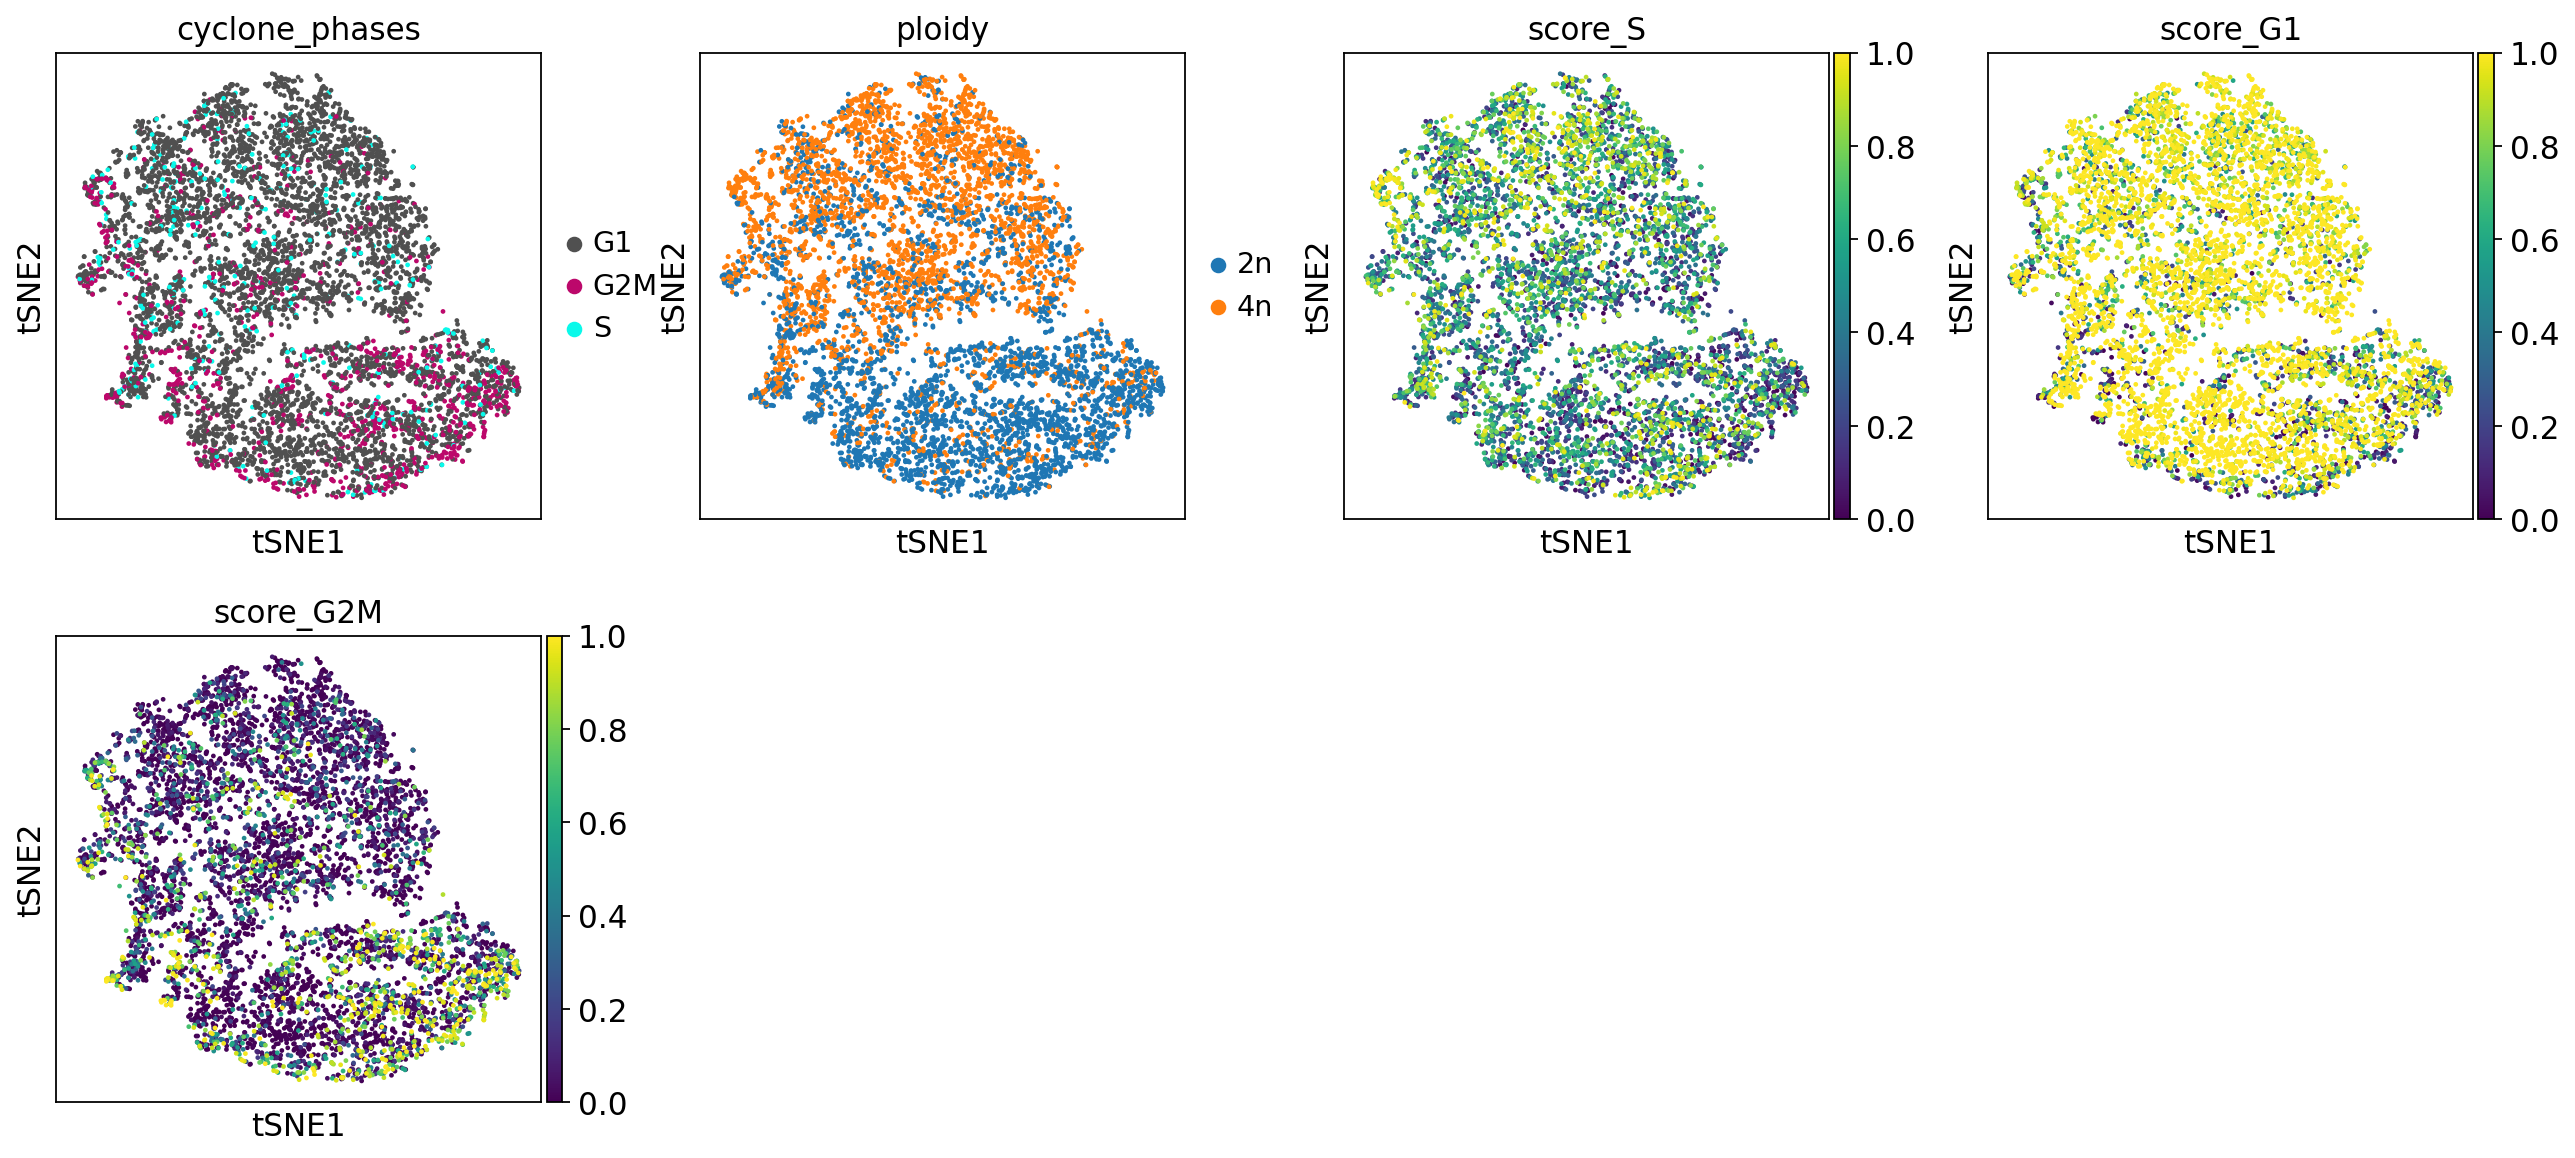

In [20]:
sc.pl.tsne(adata, color=["cyclone_phases","ploidy", "score_S", "score_G1", "score_G2M"])

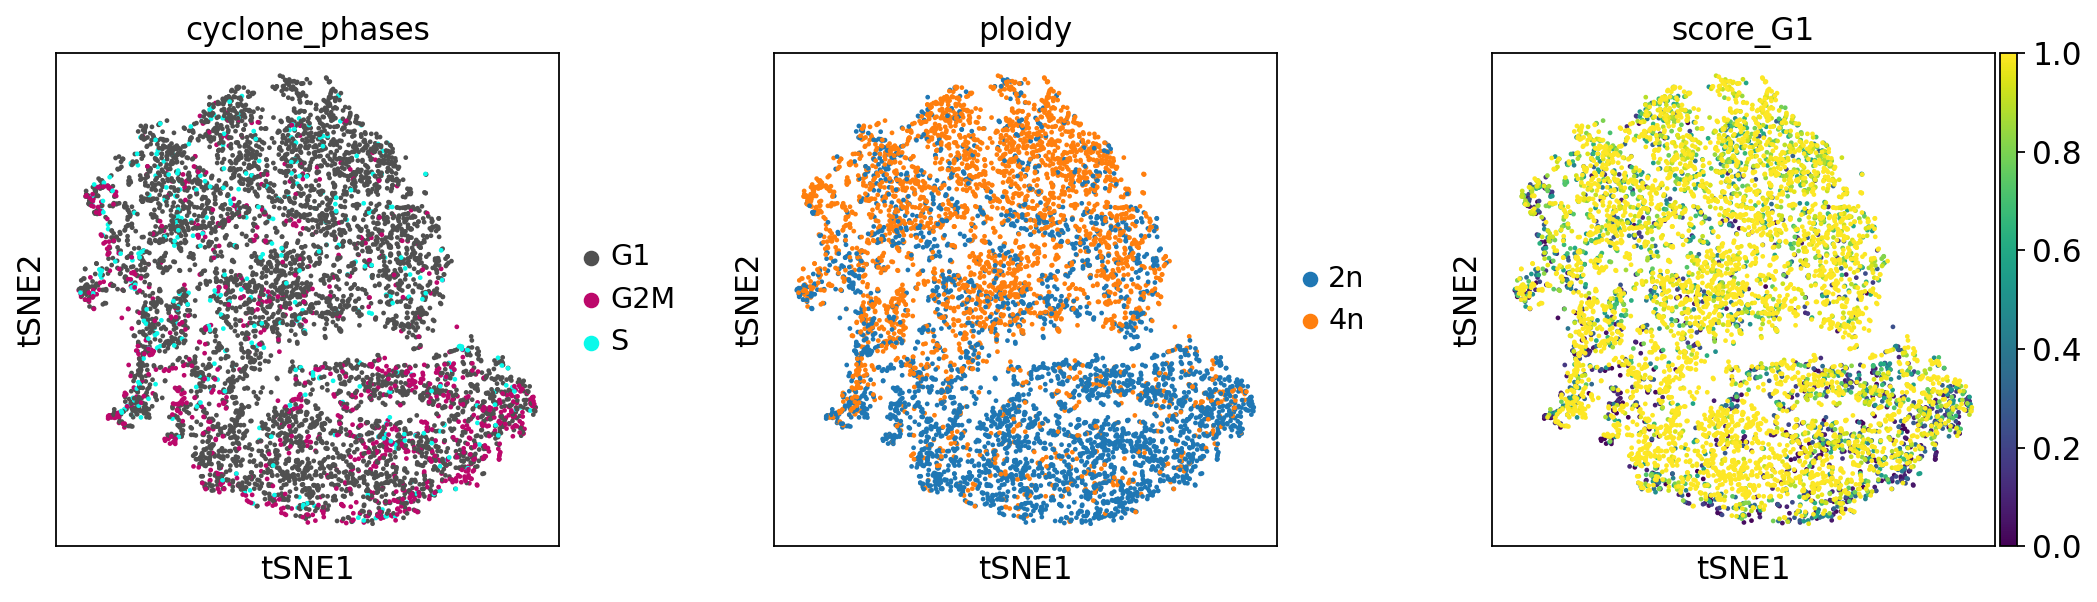

In [21]:
sc.pl.tsne(adata, color=["cyclone_phases","ploidy", "score_G1"], wspace=0.3, save='_cell_cycle.pdf')

In [22]:
adata

AnnData object with n_obs × n_vars = 6605 × 30520
    obs: 'batch', 'exp.', 'libraryID', 'experiment', 'strain', 'age', 'sex', 'ploidy', 'ERCC.dilution', 'column', 'row', 'percentERCC', 'n_counts', 'age_grouped', 'n_counts_raw', 'n_counts_transcripts', 'n_counts_ERCC', 'n_genes', 'high_ERCC', 'low_ERCC', 'low_genes', 'high_genes', 'low_counts', 'high_counts', 'ERCC_size_factor', 'n_counts_TPM', 'RPK_factor', 'n_counts_TPM_norm', 'mean_transcript_count_TPM', 'cyclone_phases', 'score_G1', 'score_S', 'score_G2M'
    var: 'length', 'gene_name', 'chromosomes', 'start', 'end', 'n_counts', 'mean_exp_TPM', 'median_exp_TPM'
    uns: 'ERCC.dilution_colors', 'age_colors', 'age_grouped_colors', 'cyclone_phases_colors', 'exp._colors', 'neighbors', 'pca', 'ploidy_colors', 'strain_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts', 'raw', 'raw_bin'
    obsp: 'connectivities', 'distances'

# Cell cycle analysis per strain

In [11]:
phases_strain = dict()
score_G1_strain = dict()
score_S_strain = dict()
score_G2M_strain = dict()

## Wild type

In [12]:
strain_key = 'C57Bl6/J'

In [13]:
adata_strain = adata[adata.obs['strain']==strain_key].copy()

Prepare data for R interface.

In [14]:
data_mat = adata_strain.X.T
gnames = adata_strain.var_names.tolist()
cnames = adata_strain.obs_names.tolist()

Run `cyclone` via `rpy2`.

In [15]:
%%R -i data_mat -i gnames -i cnames -o phases -o scores

library(scran)
# cell cycle analysis using cyclone
# should be easy because it's implemented in scran
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

rownames(data_mat) <- gnames
colnames(data_mat) <- cnames

score_list <- cyclone(data_mat, mm.pairs, gene.names=rownames(data_mat), 
                      iter=1000, min.iter=100, min.pairs=50,  BPPARAM=SerialParam(),#bpparam(), 
                      verbose=FALSE)

phases <- score_list$phases
scores <- score_list$scores

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

In [16]:
phases_strain[strain_key] = phases
score_G1_strain[strain_key] = scores["G1"].tolist()
score_S_strain[strain_key] = scores["S"].tolist()
score_G2M_strain[strain_key] = scores["G2M"].tolist()

## CEBPA KO

In [20]:
strain_key = 'CEBPA KO'

In [21]:
adata_strain = adata[adata.obs['strain']==strain_key].copy()

Prepare data for R interface.

In [22]:
data_mat = adata_strain.X.T
gnames = adata_strain.var_names.tolist()
cnames = adata_strain.obs_names.tolist()

Run `cyclone` via `rpy2`.

In [24]:
%%R -i data_mat -i gnames -i cnames -o phases -o scores

library(scran)
# cell cycle analysis using cyclone
# should be easy because it's implemented in scran
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

rownames(data_mat) <- gnames
colnames(data_mat) <- cnames

score_list <- cyclone(data_mat, mm.pairs, gene.names=rownames(data_mat), 
                      iter=1000, min.iter=100, min.pairs=50,  BPPARAM=SerialParam(),#bpparam(), 
                      verbose=FALSE)

phases <- score_list$phases
scores <- score_list$scores

In [25]:
phases_strain[strain_key] = phases
score_G1_strain[strain_key] = scores["G1"].tolist()
score_S_strain[strain_key] = scores["S"].tolist()
score_G2M_strain[strain_key] = scores["G2M"].tolist()

## HNF4 KO

In [26]:
strain_key = 'HNF4 KO'

In [27]:
adata_strain = adata[adata.obs['strain']==strain_key].copy()

Prepare data for R interface.

In [28]:
data_mat = adata_strain.X.T
gnames = adata_strain.var_names.tolist()
cnames = adata_strain.obs_names.tolist()

Run `cyclone` via `rpy2`.

In [29]:
%%R -i data_mat -i gnames -i cnames -o phases -o scores

library(scran)
# cell cycle analysis using cyclone
# should be easy because it's implemented in scran
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

rownames(data_mat) <- gnames
colnames(data_mat) <- cnames

score_list <- cyclone(data_mat, mm.pairs, gene.names=rownames(data_mat), 
                      iter=1000, min.iter=100, min.pairs=50,  BPPARAM=SerialParam(),#bpparam(), 
                      verbose=FALSE)

phases <- score_list$phases
scores <- score_list$scores

In [30]:
phases_strain[strain_key] = phases
score_G1_strain[strain_key] = scores["G1"].tolist()
score_S_strain[strain_key] = scores["S"].tolist()
score_G2M_strain[strain_key] = scores["G2M"].tolist()

## CTCF KO

In [31]:
strain_key = 'CTCF KO'

In [32]:
adata_strain = adata[adata.obs['strain']==strain_key].copy()

Prepare data for R interface.

In [33]:
data_mat = adata_strain.X.T
gnames = adata_strain.var_names.tolist()
cnames = adata_strain.obs_names.tolist()

Run `cyclone` via `rpy2`.

In [34]:
%%R -i data_mat -i gnames -i cnames -o phases -o scores

library(scran)
# cell cycle analysis using cyclone
# should be easy because it's implemented in scran
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

rownames(data_mat) <- gnames
colnames(data_mat) <- cnames

score_list <- cyclone(data_mat, mm.pairs, gene.names=rownames(data_mat), 
                      iter=1000, min.iter=100, min.pairs=50,  BPPARAM=SerialParam(),#bpparam(),  
                      verbose=FALSE)

phases <- score_list$phases
scores <- score_list$scores

In [35]:
phases_strain[strain_key] = phases
score_G1_strain[strain_key] = scores["G1"].tolist()
score_S_strain[strain_key] = scores["S"].tolist()
score_G2M_strain[strain_key] = scores["G2M"].tolist()

## Merge values

In [66]:
adata.obs['phase_strain'] = pd.Series(np.repeat('', adata.n_obs))
adata.obs['G1_strain'] = pd.Series(np.repeat(0, adata.n_obs))
adata.obs['S_strain'] = pd.Series(np.repeat(0, adata.n_obs))
adata.obs['G2M_strain'] = pd.Series(np.repeat(0, adata.n_obs))

for strain_key in adata.obs['strain'].unique():
    strain_idx = adata.obs['strain']==strain_key
    adata.obs['phase_strain'][strain_idx] = phases_strain[strain_key]
    adata.obs['G1_strain'][strain_idx] = score_G1_strain[strain_key]
    adata.obs['S_strain'][strain_idx] = score_S_strain[strain_key]
    adata.obs['G2M_strain'][strain_idx] = score_G2M_strain[strain_key]

<ipython-input-66-c01f2d910bc3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['phase_strain'][strain_idx] = phases_strain[strain_key]
<ipython-input-66-c01f2d910bc3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['G1_strain'][strain_idx] = score_G1_strain[strain_key]
<ipython-input-66-c01f2d910bc3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['S_strain'][strain_idx] = score_S_strain[strain_key]
<

Compare the results for cyclone on all cells and per strain.

In [46]:
pd.crosstab(adata.obs['cyclone_phases'], adata.obs['phase_strain'])

phase_strain,G1,G2M,S
cyclone_phases,,,
G1,5232,8,12
G2M,4,970,10
S,9,8,352


In [58]:
pd.crosstab(adata.obs['strain'], [adata.obs['phase_strain'], adata.obs['cyclone_phases'] ]).to_csv(f'../tables/{today}_compare_cyclone.csv')

In [ ]:
adata.write(data_dir + 'snRNAseq_mouse_hepatocytes_all_cells_filtered_TPM_mar21.h5ad')

... storing 'phase_strain' as categorical


# Get cell type proportions

Get the cell numbers per cell cycle stage.

In [40]:
meta_info = adata.obs[['age_grouped', 'strain', 'phase_strain']]
meta_info['cell_count'] = 'cell_count'

<ipython-input-40-9a3f6d01d817>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_info['cell_count'] = 'cell_count'


In [41]:
tmp = meta_info.groupby(['age_grouped',
                         'phase_strain', 'strain','cell_count'])['age_grouped'].count().unstack()

In [42]:

tmp = tmp.rename(columns=str).reset_index()

In [43]:
tmp

cell_count,age_grouped,phase_strain,strain,cell_count
0,young,G1,C57Bl6/J,1406
1,young,G1,CEBPA KO,828
2,young,G1,CTCF KO,322
3,young,G1,HNF4 KO,299
4,young,G2M,C57Bl6/J,214
5,young,G2M,CEBPA KO,0
6,young,G2M,CTCF KO,149
7,young,G2M,HNF4 KO,170
8,young,S,C57Bl6/J,113
9,young,S,CEBPA KO,0


In [53]:
tmp.to_csv(f'./../tables/{today}_cyclone_phase_total_count.csv')

When computing the proportions, we have to take into account that plates SNI-667 contains only 2n nuclei, while the rest is sorted 50:50 2n:4n.

In [54]:
tmp2 = tmp.groupby(['age_grouped', 'strain']).transform(lambda x: x *100/ x.sum())

In [55]:
tmp2[['age_grouped', 'phase_strain', 'strain']] = tmp[['age_grouped',  'phase_strain', 'strain',]]

In [56]:
tmp2.to_csv(f'./../tables/{today}_cyclone_phase_per-strain_total_proportions_separate_annotation.csv')